# Classification of handwritten digits using Pytorch

In [1]:
from typing import List, Dict, Tuple, Optional, Callable, Iterable

import torch
import torch.nn as nn
from torch.optim import Optimizer, Adadelta
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torchmetrics import Accuracy

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

In [2]:
# The preprocessing transformations
transforms = v2.Compose([v2.ToImage(), # Converts to tensor
                         # Sets the dtype and each scale each pixel between [0, 1]
                         v2.ToDtype(torch.float32, scale=True)])

# Train set
train_set = datasets.MNIST(root="./data",
                           train=True,
                           download=True,
                           transform=transforms)
# Evaluation set
eval_set = datasets.MNIST(root="./data",
                          train=False,
                          download=True, 
                          transform=transforms)

print(f"Train set shape: {train_set.data.shape}")
print(f"Eval set shape: {eval_set.data.shape}")

Train set shape: torch.Size([60000, 28, 28])
Eval set shape: torch.Size([10000, 28, 28])


In [3]:
# Creating the dataloaders
torch.manual_seed(42)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
eval_loader = DataLoader(eval_set, batch_size=32, shuffle=False)

In [4]:
# The model
class ConvNet(nn.Module):
    """
    A Convolutional Neural Network (CNN) for 
    classifying 28x28 monochromatic images into 10 classes.

    Input:
    - Shape: (batch_size, 1, 28, 28) for monochromatic images.

    Output:
    - Shape: (batch_size, 10) representing the class 
        probabilities for each image in the batch.
    """
    def __init__(self) -> None:
        """
        Initializes the ConvNet model with a feature extractor and a classifier.
        """
        super(ConvNet, self).__init__()
        # Features block
        self.features = nn.Sequential(
            # shape in: (batch_size, 1, 28, 28)
            # shape out: (batch_size, 16, 26, 26)
            # nn.BatchNorm2d(num_features=1), 
            nn.Conv2d(in_channels=1, # Monochromatic images
                      out_channels=16,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),  # (batch_size, 32, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (batch_size, 32, 12, 12)
            nn.Dropout2d(p=0.1),
            nn.Flatten()  # (batch_size, 4608)
        )
        # Classifier DNN
        self.classifier = nn.Sequential(
            nn.Linear(4608, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 10),  # num classes
            nn.Softmax(dim=-1)
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        Args:
        - inputs (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28) 
            representing a batch of monochromatic images.

        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, 10)
            representing the class probabilities for each image in the batch.
        """
        # Forward pass
        features = self.features(inputs)
        probabilities = self.classifier(features)
        return probabilities

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params = count_parameters(ConvNet())
print(f"Count of trainable params: {n_params:,.0f}")

Count of trainable params: 300,426


In [6]:
def train_one_epoch(model: nn.Module,
                    train_loader: DataLoader,
                    criterion: nn.Module,
                    optimizer: Optimizer,
                    epoch: int,
                    device: Optional[torch.device]=None) -> float:
    """
    Trains the model for one epoch.

    Args:
    - model (nn.Module): The neural network model to be trained.
    - train_loader (DataLoader): The DataLoader providing the training data.
    - criterion (nn.Module): The loss function used for optimization.
    - optimizer (Optimizer): The optimizer used to update the model's weights.
    - epoch (int): The current epoch number.
    - device (Optional[torch.device]): The device (CPU or GPU) to which data and the model should be transferred. 
                                       If None, defaults to CPU.

    Returns:
    - float: The average training loss over the epoch.
    """
    model.train()
    train_loss = 0
    # Progress bar
    pbar = tqdm(train_loader, 
                total=len(train_loader), 
                desc=f"Train - epoch {epoch}")
    for batch_id, (inputs, targets) in enumerate(pbar, start=1):
        # Zero the gradients
        optimizer.zero_grad()
        # Send inputs and targets to proper device
        if device is not None:
            inputs = inputs.to(device)
            targets = targets.to(device)

        outputs = model(inputs)
        # Calculate loss
        loss = criterion(outputs, targets)
        # Calculate gradients
        loss.backward()
        # Update the models' weights
        optimizer.step()
        # Store the training loss
        train_loss += loss.item()
        pbar.update(1)
        pbar.set_postfix({"train_loss": f"{train_loss/batch_id:.4f}"})
    return train_loss / len(train_loader)

In [7]:
def evaluate_model(model: nn.Module,
                   eval_loader: DataLoader,
                   criterion: nn.Module,
                   epoch: int,
                   device: Optional[torch.device]=None) -> Tuple[float, float]:
    """
    Evaluates the model for one epoch.

    Args:
    - model (nn.Module): The neural network model to be trained.
    - eval_loader (DataLoader): The DataLoader with the validation data.
    - criterion (nn.Module): The loss function.
    - epoch (int): The current epoch number.
    - device (Optional[torch.device]): The device (CPU or GPU) to which data and the model should be transferred. 
                                       If None, defaults to CPU.

    Returns:
    - Tuple[float, float]: The average evaluation loss and accuracy over the epoch.
    """
    model.eval()
    eval_loss = 0
    # Instantiate the accuracy scorer
    scorer = Accuracy(task="multiclass", num_classes=10)
    pbar = tqdm(eval_loader, 
                total=len(eval_loader), 
                desc=f"Eval - epoch {epoch}")
    # Disable gradients tracking and speedup inference
    with torch.no_grad():
        for batch_id, (inputs, targets) in enumerate(pbar, start=1):
            if device is not None:
                inputs = inputs.to(device)
                targets = targets.to(device)
    
            outputs = model(inputs)
            # Calculate loss and accuracy
            loss = criterion(outputs, targets)
            scorer.update(outputs, targets)
            # Store the training loss
            eval_loss += loss.item()
            pbar.update(1)
            eval_score = scorer.compute().item()
            pbar.set_postfix({"eval_loss": f"{eval_loss/batch_id:.4f}", 
                              "eval_acc": f"{eval_score:.4f}"})
    return eval_loss / len(eval_loader), eval_score

In [8]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                eval_loader: DataLoader,
                criterion: nn.Module,
                optimizer: Optimizer,
                n_epochs: Optional[int]=10,
                device: Optional[torch.device]=None) -> Dict[str, List[float]]:
    """    
    Args:
    - model (nn.Module): The neural network model to be trained and evaluated.
    - train_loader (DataLoader): The DataLoader providing the training data.
    - eval_loader (DataLoader): The DataLoader providing the evaluation data.
    - criterion (nn.Module): The loss function used for both training and evaluation.
    - optimizer (Optimizer): The optimizer used to update the model's weights.
    - n_epochs (Optional[int]): The number of epochs to train the model, default is 10.
    - device (Optional[torch.device]): The device (CPU or GPU) on which to perform computations. Defaults to CPU if not provided.

    Returns:
    - dict: A dictionary containing the history of the training process, with keys:
        - "epoch": List of epoch numbers.
        - "train_loss": List of average training losses per epoch.
        - "eval_loss": List of average evaluation losses per epoch.
        - "eval_acc": List of accuracy scores per epoch.
    """
    hist = {
        "epoch": [],
        "train_loss": [],
        "eval_loss": [],
        "eval_acc": []
    }
    for epoch in range(1, n_epochs + 1):
        # Train
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, epoch, device)
        # Evaluate
        eval_loss, eval_acc = evaluate_model(model, eval_loader, criterion, epoch, device)
        # Update training history
        hist["epoch"].append(epoch)
        hist["train_loss"].append(train_loss)
        hist["eval_loss"].append(eval_loss)
        hist["eval_acc"].append(eval_acc)
    return hist

In [9]:
%%time
torch.manual_seed(42)

# Instantiate the model
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = Adadelta(model.parameters())
n_epochs = 3
device = "cpu"

hist = train_model(model, train_loader, eval_loader, criterion, optimizer, n_epochs, device)

Train - epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Eval - epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Train - epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Eval - epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Train - epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Eval - epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

CPU times: user 6min 40s, sys: 4.18 s, total: 6min 45s
Wall time: 1min 40s


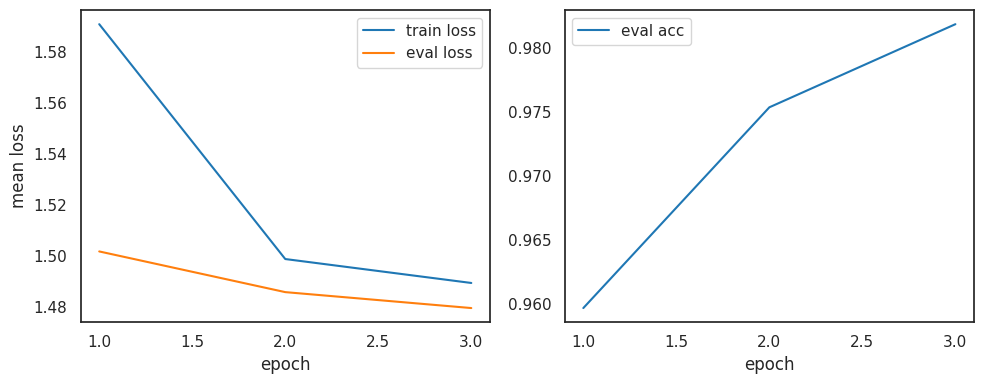

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
sns.lineplot(x=hist["epoch"], y=hist["train_loss"], label="train loss", ax=axes[0])
sns.lineplot(x=hist["epoch"], y=hist["eval_loss"], label="eval loss", ax=axes[0])
sns.lineplot(x=hist["epoch"], y=hist["eval_acc"], label="eval acc", ax=axes[1])
for ax in axes:
    ax.set_xlabel("epoch")
axes[0].set_ylabel("mean loss")
fig.tight_layout()
plt.show()

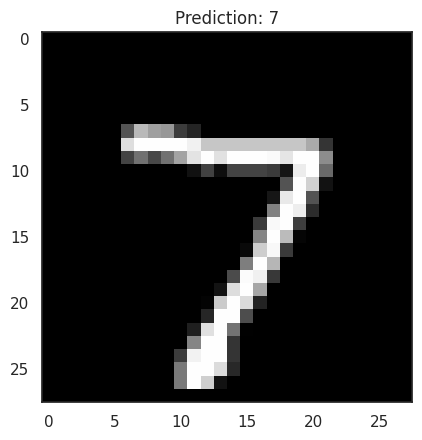

In [11]:
def plot_sample(sample_img: torch.Tensor, 
                model: nn.Module) -> None:
    """
    Plots a sample image and run inference.
    """
    model.eval()
    with torch.no_grad():
        # Adding the 'batch' dimension
        inputs = sample_img.unsqueeze(0) # (1, 1, 28, 28)
        probs = model(inputs)
    # Removing the channel and ploting
    fig, ax = plt.subplots()
    ax.imshow(sample_img.squeeze(0), # (28 x 28)
               cmap="gray",
               interpolation="none")
    # Fetching the predicted label
    ax.set_title(f"Prediction: {torch.argmax(probs)}")
    plt.show()

sample_img, _ = eval_set[0]
plot_sample(sample_img, # (1, 28, 28)
            model)